In [2]:
import torch 
import torch.nn as nn 


In [12]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256, # i have reduced context lenght 
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}

In [13]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, D_in = x.shape

        Q = self.W_query(x)  # (B, T, D_out)
        K = self.W_key(x)    # (B, T, D_out)
        V = self.W_value(x)  # (B, T, D_out)


        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T, head_dim)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, num_heads, T, T)

        mask = self.mask[:T, :T].bool()
        attn_scores = attn_scores.masked_fill(mask[None, None, :, :], float('-inf'))

        # Softmax and dropout
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention
        context = attn_weights @ V  # (B, num_heads, T, head_dim)

        # Merge heads back
        context = context.transpose(1, 2).contiguous().view(B, T, self.d_out)
        context = self.out_proj(context)

        return context

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
        ))

In [15]:
class FeedForward(nn.Module): 
    def __init__(self,cfg:dict): 
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
            GELU(), 
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    
    def forward(self,x): 
        return self.layers(x) 


In [16]:
class LayerNorm(nn.Module): 
    def __init__(self,emb_dim): 
        super().__init__() 
        self.eps = 1e-5 
        self.scale = nn.Parameter(torch.ones(emb_dim)) 
        self.shift = nn.Parameter(torch.zeros(emb_dim)) 
    
    def forward(self,x): 
        mean = x.mean(dim=-1,keepdim=True) 
        var = x.var(dim=-1,keepdim=True,unbiased=False) 
        norm_x  = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift # we are not forcing them to be gausian , model 
        # can do what it whant here :) 



In [31]:
class TransformerBlock(nn.Module): 
    def __init__(self,cfg:dict):
        super().__init__() 
        self.att = MultiHeadAttention(
            d_in= cfg['emb_dim'],
            d_out = cfg['emb_dim'], 
            context_length=cfg['context_length'], 
            num_heads = cfg['n_heads'], 
            dropout = cfg['drop_rate'], 
            qkv_bias=cfg['qkv_bias'] 
        )
        self.ff = FeedForward(cfg) 
        self.norm1 = LayerNorm(cfg['emb_dim']) 
        self.norm2 = LayerNorm(cfg['emb_dim']) 
        self.drop_shortcut = nn.Dropout(cfg['drop_rate']) 
    
    def forward(self,x): 
        shortcut = x 
        x = self.norm1(x) 
        x = self.att(x) 
        x = self.drop_shortcut(x) 
        x = x + shortcut 

        shortcut = x 
        x = self.norm2(x) 
        x = self.ff(x)  
        x = self.drop_shortcut(x) 
        x = x + shortcut 
        return x 


In [32]:
class GPTModel(nn.Module): 
    def __init__(self,cfg:dict): 
        super().__init__() 
        self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim']) 
        self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim']) 
        self.drop_emb = nn.Dropout(cfg['drop_rate']) 

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim']) 

        self.out_head = nn.Linear( 
            cfg['emb_dim'], cfg['vocab_size'],bias=False
        )
    
    def forward(self,in_idx:torch.Tensor): 
        batch_size, sq_len =  in_idx.shape 
        tok_embeds = self.tok_emb(in_idx)  
        pos_embeds = self.pos_emb(
            torch.arange(sq_len,device=in_idx.device)
        )
        x = tok_embeds + pos_embeds 
        x = self.drop_emb(x) 
        x = self.trf_blocks(x) 
        x = self.final_norm(x) 
        logits = self.out_head(x) 
        return logits 

In [33]:
def generate_text_simple(model,idx,max_new_tokens,context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] 
        with torch.no_grad(): 
            logits = model(idx_cond) 
        logits = logits[:,-1,:]
        probas = torch.softmax(logits,dim=-1) 
        idx_next = torch.argmax(probas,dim=-1,keepdim=True) 
        idx = torch.cat((idx,idx_next),dim=1) 
    return idx 

In [34]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [35]:
import tiktoken  


In [36]:
def text_to_token(text,tokenizer): 
    encoded = tokenizer.encode(text,allowed_special={"<|endoftext|>"}) 
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor 

In [37]:
def token_ids_to_text(token_ids:torch.Tensor,tokenizer): 
    flat = token_ids.squeeze(0) # remove batch dimenstion 
    return tokenizer.decode(flat.tolist())
    

In [38]:
start_context = "Every effort moves you" 
tokenizer = tiktoken.get_encoding("gpt2") 
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token(start_context,tokenizer), 
    max_new_tokens=10, 
    context_size = GPT_CONFIG_124M['context_length']
)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [39]:
inputs = torch.tensor([[16833, 3626, 6100],
[40,
1107, 588]])
# ["every effort moves",
# "I really like"]

In [40]:
targets = torch.tensor([[3626, 6100, 345 ],
[1107, 588, 11311]])

In [41]:
with torch.no_grad(): 
    logits = model(inputs) 

probas = torch.softmax(logits,dim=-1) 
print(probas.shape)

torch.Size([2, 3, 50257])


In [42]:
token_ids = torch.argmax(probas,dim=-1,keepdim=True) 
print("Token IDs:\n",token_ids) 
print(token_ids.shape)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
torch.Size([2, 3, 1])


In [43]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [44]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [45]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [47]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas) # -loss , loss = -avg_log_probs 

print(-avg_log_probas)

tensor(-10.7940)
tensor(10.7940)


In [49]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas) # this is known as cross entropy 

tensor(10.7940)


In [50]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [51]:
# before using cross entropy you need to flatten  on batch and time dimention like this 
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [52]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


perplexity is a measure often used along side cross entropy loss to evaluate the performance of models in tasks like lagunage modeling. it can provide a more interpretable way to understand the uncertainty of a model in predicting the next token in a sequence. 
perplexity measures how well the probability distribution predicted by the mode matches the actual distribution of the words in a dataset. Similar to the loss , a lower perplexity indicates the model predictions are closer to the actual distribution . Perplexity can be cacluated as ` perplexity = torch.exp(loss)` which returns tensor(48725.8203) when applied to the previously caclated loss. 

perplexity is often considered more interpretable than the raw loss value because it signifies teh effective vocabulary size about which the model is uncertain at each step. In the given exampe , this would translate to the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token 

In [53]:
# we will apply the loss computation to the entire training and validation sets. 
file_path = "../the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [54]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [55]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [56]:
from torch.utils.data import Dataset, DataLoader 

In [57]:
class GPTDatasetV1(Dataset): 
    def __init__(self,txt,tokenizer,max_length,stride): 
        self.input_ids = [] 
        self.target_ids = []

        token_ids = tokenizer.encode(txt) 

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
        
    def __len__(self): 
        return len(self.input_ids) 
    
    def __getitem__(self,idx): 
        return self.input_ids[idx] , self.target_ids[idx] 

In [58]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                    stride=128, shuffle=True, drop_last=True,
                    num_workers=0):
                    
                    tokenizer  = tiktoken.get_encoding('gpt2') 
                    dataset = GPTDatasetV1(txt,tokenizer,max_length,stride) 
                    dataloader = DataLoader(
                        dataset, 
                        batch_size=batch_size, 
                        shuffle=shuffle, 
                        drop_last=drop_last, 
                        num_workers=num_workers
                    )
                    return dataloader 

In [59]:
train_loader = create_dataloader_v1(
train_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=True,
shuffle=True,
num_workers=0
)
val_loader = create_dataloader_v1(
val_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=False,
shuffle=False,
num_workers=0
)

In [60]:

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [61]:
def calc_loss_batch(input_batch,target_batch,model,device): 
    input_batch = input_batch.to(device) 
    target_batch = target_batch.to(device) 
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()
    )
    return loss 

In [62]:
def calc_loss_loader(data_loader,model,device,num_batches=None): 
    total_loss = 0 
    if len(data_loader) == 0: 
        return float("nan") 
    elif num_batches is None: 
        num_batches = len(data_loader) 
    else: 
        num_batches = min(num_batches,len(data_loader)) 
    
    for i ,(input_batch,target_batch) in enumerate(data_loader): 
        if i < num_batches: 
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            ) 
            total_loss += loss.item() 
        else: 
            break 

    return total_loss / num_batches 

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.eval() # model to eval mode 

with torch.inference_mode(): # more modern and potentaly fast
    train_loss = calc_loss_loader(train_loader,model,device) 
    val_loss = calc_loss_loader(val_loader,model,device) 

print("Training loss",train_loss) 
print(" Validation loss",val_loss)

Training loss 10.987583266364204
 Validation loss 10.98110580444336


In [66]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter): 
    model.eval() 
    with torch.inference_mode(): # modern 
        train_loss = calc_loss_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader,model,device,num_batches=eval_iter
        )
    model.train() # turn back model to train mode 
    return train_loss, val_loss 

In [67]:
from base64 import decode


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval() # evaluation mode 
    context_size = model.pos_emb.weight.shape[0] 
    encoded = text_to_token(start_context,tokenizer).to(device) 
    with torch.no_grad(): 
        token_ids = generate_text_simple(
            model=model,idx=encoded,max_new_tokens=50,context_size=context_size
        )
    
    decoded_text = token_ids_to_text(token_ids,tokenizer) 
    print(decoded_text.replace("\n",""))
    model.train # back to train mode 

In [68]:
# Training an LLM 
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,
                        eval_freq,eval_iter,start_context,tokenizer): 
                        #---------------------------------
                        train_losses , val_losses, track_tokens_seen = [],[], [] 
                        tokens_seen, global_step = 0 , -1 
                        for epoch in range(num_epochs): 
                            model.train() # model to train model  
                            for input_batch,target_batch in train_loader: 
                                optimizer.zero_grad() 
                                loss = calc_loss_batch(
                                    input_batch,target_batch,model,device
                                )   
                                loss.backward() 
                                optimizer.step() 
                                tokens_seen += input_batch.numel() 
                                gobal_step += 1 

                                if global_step % eval_freq == 0: 
                                    train_loss, val_loss = evaluate_model(
                                        model, train_loader,val_loader,device,eval_iter
                                    )  

                                    train_losses.append(train_loss) 
                                    val_losses.append(val_loss) 
                                    track_tokens_seen.append(tokens_seen) 
                                    print(
                                        f"EP {epoch +1} ( Step {global_step:06d}):"
                                        f"Train loss {train_loss:.3f},"
                                        f"Val loss {val_loss:.3f}"
                                    )          
                            generate_and_print_sample(
                                model,tokenizer,device,start_context
                            )
                        
                        return train_loss, val_loss, track_tokens_seen 



In [ ]:
""" 
Adam optimizers are a popular choice for training deep neural networks. However, in
our training loop, we opt for the AdamW optimizer. AdamW is a variant of Adam that
improves the weight decay approach, which aims to minimize model complexity and
prevent overfitting by penalizing larger weights. This adjustment allows AdamW to
achieve more effective regularization and better generalization; thus, AdamW is fre-
quently used in the training of LLMs
""" 

import token


torch.manual_seed(123) 
model = GPTModel(GPT_CONFIG_124M) 
model.to(device) # :( 
# model.compile() # :)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr = 0.0004 , 
    weight_decay=0.1 
)
num_epochs = 10 
train_losses, val_losses , token_seen = train_model_simple(
    model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq=5,eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer
) # thier is a problem with my env i will fix later 

AttributeError: partially initialized module 'torch._dynamo' from '/home/njue/Dev/LLMFromScratch/.venv/lib/python3.13/site-packages/torch/_dynamo/__init__.py' has no attribute 'decorators' (most likely due to a circular import)

In [72]:
torch.__version__

'2.9.0+cpu'

In [73]:
# plotting code 

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
#plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


NameError: name 'num_epochs' is not defined

In [74]:

model.to('cpu') 
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [75]:
tokenizer = tiktoken.get_encoding("gpt2") 
token_ids = generate_text_simple(
    model = model, 
    idx = text_to_token("every effort moves you",tokenizer), 
    max_new_tokens=25, 
    context_size=GPT_CONFIG_124M['context_length']
)
print("output text: \n",token_ids_to_text(token_ids,tokenizer)) 

output text: 
 every effort moves you rentingetic minion mobilized Macicone heterogeneity achaRAMlevision TT TelegramCustomer connector commander Mobil RBI transpiredestine formulations32 stereo vocabularyLD


In [76]:
# temperature scaling 
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [77]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [78]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [79]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [82]:
def print_sampled_tokens(probas): 
    torch.manual_seed(123) 
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample)) 
    for i , freq in enumerate(sampled_ids): 
        print(f"{freq} x {inverse_vocab[i]}") 
    


print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [83]:
# temperature scaling, you divide the logits with the temp 
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

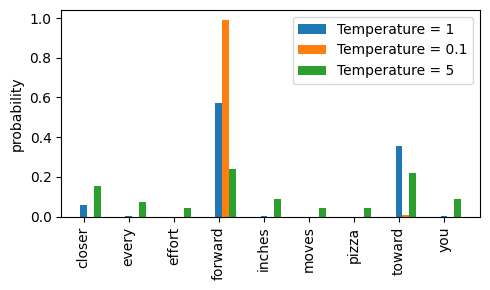

In [85]:


temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits,T) for T in temperatures] 

x = torch.arange(len(vocab)) 
bar_width  = 0.15 
fig, ax = plt.subplots(figsize=(5,3)) 

for i , T in enumerate(temperatures): 
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
    bar_width,label=f"Temperature = {T}") 

ax.set_ylabel("probability") 
ax.set_xticks(x) 
ax.set_xticklabels(vocab.keys(),rotation=90) 
ax.legend() 
plt.tight_layout() 
plt.show() 

In [86]:
# Top-k sampling 

top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [88]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], 
    input=torch.tensor(float('-inf')), 
    other= next_token_logits
)

In [89]:
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [90]:
topk_probas = torch.softmax(new_logits,dim=0) 
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [93]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens): 
        idx_cond = idx[:,-context_size:]  
        with torch.no_grad(): 
            logits = model(idx_cond) 
        
        logits = logits[:,-1,:]

        if top_k is not None: 
            top_logits,_ = torch.topk(logits,top_k) 
            min_val = top_logits[:,-1] 
            logits = torch.where(
                logits < min_val, 
                torch.tensor(float('-inf')).to(logits.device), 
                logits 
            )
        if temperature > 0.0: 
            logits = logits / temperature # :) 
            probs  = torch.softmax(logits,dim=-1) 
            idx_next = torch.multinomial(probs,num_samples=1)
        else: 
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)
        if idx_next == eos_id: 
            break 
        idx = torch.cat((idx,idx_next),dim=1) # C 
    return idx 
    

In [94]:

torch.manual_seed(123) 

token_ids = generate(
    model = model, 
    idx = text_to_token("Every effort moves you",tokenizer) , 
    max_new_tokens=15, 
    context_size = GPT_CONFIG_124M['context_length'], 
    top_k = 25, 
    temperature = 1.4, 
    
)

In [95]:
print("output text: \n",token_ids_to_text(token_ids,tokenizer))

output text: 
 Every effort moves youEveryiliaralso stabbed OrleansAllowsean 52anche crime winter unbeaten quoteembedreportprint earning


In [96]:
# Loading and saving model weights in PyTorch
torch.save(model.state_dict(), "model.pth")

In [ ]:
# lading the model state dict 
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

In [ ]:
torch.save({
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
},
"model_and_optimizer.pth" # this is because adam has some invo for buffers to save 
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device) # first create a chepoint 
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train() #:) , that the workflow

In [ ]:
# Loading pretrained weights from OpenAI 

"""
Note that openai origially saved the gpt2 weights via tensorflow which we have to install 
to load the weights in python, the following code wil use a progress bar tool 
called tqdm to track the download process, which we alos have to install . 
""" 
!pip install tensorflow>=2.15.0 
!pip install tqdm 

In [ ]:
import urllib.request 

url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)


In [ ]:
""" 
we can now imprt the downad_and_load_gpt2 functin from the gpt_dowload.py file 
as follows , which will load the GPT2 architecure settings and weight parameters into our python 
session: 
""" 

from gpt_download import download_and_load_gpt_2 #noqa 
settings, params = download_and_load_gpt2(
model_size="124M", models_dir="gpt2"
)


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

In [ ]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [ ]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [ ]:
NEW_CONFIG.update({"context_length": 1024})

In [ ]:
NEW_CONFIG.update({"qkv_bias": True})

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
        "Right: {right.shape}"
    )
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np 
#... i will continue from here 